<a href="https://colab.research.google.com/github/LUMII-AILab/NLP_Course/blob/main/notebooks/NaiveBayes.ipynb" target="_new"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Naïve Bayes text classifier

Hands-on dataset: *20 Newsgroup* assembled by Ken Lang @ CMU.

https://www.kaggle.com/datasets/au1206/20-newsgroup-original

We will use a format-converted, single-file version available from the course GitHub repo.

## Setting up the environment

In [ ]:
!wget https://raw.githubusercontent.com/LUMII-AILab/NLP_Course/main/notebooks/resources/news20/20_newsgroup.tsv

!wget https://raw.githubusercontent.com/LUMII-AILab/NLP_Course/main/notebooks/resources/news20/20_newsgroup-freq.tsv

!wget https://raw.githubusercontent.com/LUMII-AILab/NLP_Course/main/notebooks/resources/news20/stoplist.txt

In [ ]:
!pip install nltk
!pip install scikit-learn
!pip install seaborn

In [ ]:
import nltk
nltk.download('punkt_tab') # A pre-trained tokenizer

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy

import seaborn
import matplotlib.pyplot as mplot

import re
import pickle

## Text preprocessing

In [4]:
# Initialise STOPLIST and WHITELIST

def initialise(stop_txt, freq_tsv):
	global STOPLIST
	STOPLIST = set()

	with open(stop_txt) as txt:
		for word in txt:
			STOPLIST.add(normalize_text(word.strip()))

	print("[I] Word stoplist is read:", len(STOPLIST))

	global WHITELIST
	WHITELIST = set()

	with open(freq_tsv) as tsv:
		for entry in tsv:
			freq, word = entry.strip().split("\t")

			if int(freq) < 3:
        # TODO: experiment with the threshold (e.g., 3 / 5 / 10)
				# Ignore the long tail: most words occure less than N times
				continue

			WHITELIST.add(normalize_text(word))

	print("[I] Word whitelist is read:", len(WHITELIST))

In [5]:
# Preprocess any input text

def vectorize_text(text):
	return normalize_vector({word: True for word in nltk.word_tokenize(normalize_text(text))})


def normalize_text(text):
	text = text.lower()
	text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text) # e-mail addresses
	text = re.sub(r'https?://[A-Za-z0-9./-]+|www\.[A-Za-z0-9./-]+', '', text)				# URLs
	text = re.sub(r'\d+', "100", text)																					    # numbers

	return text.strip()


def normalize_vector(vector):
	words = list(vector.keys())

	for w in words:
		if w in STOPLIST or len(w) == 1 or w not in WHITELIST:
			vector.pop(w)

	return vector

In [6]:
# Read, sort and preprocess training & test data

def read_data(file):
	data_set = {}  # topic=>samples

	with open(file) as data:
		for entry in data:
			topic, text = entry.strip().split("\t")
			data_set.setdefault(topic, []).append((vectorize_text(text), topic))

	return data_set

## Experimentation & evaluation

In [7]:
# K-fold training and validation

def cross_validate(data_set, k):
	global LABELS
	LABELS = []

	kfold = KFold(n_splits=k, shuffle=True) # To generate indices for splitting data into k folds

	data_split = {} # Folded training and test data for each category: cat=>fold=>train/test

	# Ensure balanced training and test sets for each class in each fold
	for cat in data_set:
		LABELS.append(cat)

		folds = [] # Folded training and test data for this category

		# Generate training and test indices for each fold
		for train, test in kfold.split(data_set[cat]): # K loops/folds
			# Extract training and test samples from the dataset using the train/test indices
			train_data = numpy.array(data_set[cat])[train]
			test_data = numpy.array(data_set[cat])[test]
			folds.append({"train": train_data, "test": test_data})

		data_split[cat] = folds

	validations = []   # Accuracy scores for each fold
	gold_result = []   # True labels for all samples
	silver_result = [] # Predicted labels all samples

	for i in range(k): # For each fold
		# Combine training and test data from all categories for the current fold
		train_data = numpy.concatenate([data_split[cat][i]["train"] for cat in data_split], axis=0)
		test_data = numpy.concatenate([data_split[cat][i]["test"] for cat in data_split], axis=0)

		# TRAINING and NB classifier
		nb = nltk.NaiveBayesClassifier.train(train_data)

		# EVALUATING the trained classifier
		correct = 0
		for features, gold in test_data:
			silver = nb.classify(features) # Classify each test sample
			silver_result.append(silver)
			gold_result.append(gold)
			if silver == gold: correct += 1

		validations.append(correct / len(test_data)) # Calculate overall accuracy

	return (validations, gold_result, silver_result)

In [8]:
def run_validation(data_path, k):
		print("{0}-fold cross-validation:\n".format(k))

		# Run k-fold cross-validation
		validations, gold, silver = cross_validate(read_data(data_path), k)

		# Print the average accuracy: for each cross-validation step, and overall
		for step in validations: print("{0:.2f}  ".format(step), end='')
		print("{0:.0%}".format(numpy.mean(validations)))

		# Print an evaluation report
		print(classification_report(gold, silver))

		# Print a fancy confusion matrix
		matrix = confusion_matrix(gold, silver)
		seaborn.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS)
		mplot.xticks(rotation=90)
		mplot.show()
		# TODO: compare to nltk.ConfusionMatrix(gold_total, silver_total)

## Training for production

In [9]:
def join_data(data_set):
	union = []
	for cat in data_set: union += data_set[cat]
	return union


def run_training(data_path, verbose):
		# TRAINING
		# The final (production) model is trained by using all available data (train+test)
		nb = nltk.NaiveBayesClassifier.train(join_data(read_data(data_path)))

		if verbose:
				nb.show_most_informative_features(n=10) # TODO: try with n=100

		# Save the model for later use
		with open("nb_classifier.pickle", "wb") as dmp:
				pickle.dump(nb, dmp)

## The inference part

In [10]:
def run_inference():
		# Load the pre-trained model
		with open("nb_classifier.pickle", "rb") as dmp:
				nb = pickle.load(dmp)

		while True:
				text = input("\nEnter a text to classify: ")
				if len(text) == 0: break

				# Extract text features for classification
				text_feat = vectorize_text(text)
				print("\nFeatures:", text_feat.keys(), "\n")

				# INFERENCE
				# Calculate a probability distribution over the classes
				prob_dist = nb.prob_classify(text_feat)

				# Return the probability distribution
				for label in prob_dist.samples():
						print("{0}: {1:.3f}".format(label, prob_dist.prob(label)))

				# Return the most probable class
				print("\nPrediction:", prob_dist.max())

## Execution

In [ ]:
# Initialise the stopword and word frequency lists
initialise("stoplist.txt", "20_newsgroup-freq.tsv")

5-fold cross-validation:

0.79  0.78  0.78  0.77  0.78  78%
                          precision    recall  f1-score   support

             alt.atheism       0.72      0.59      0.65       992
           comp.graphics       0.71      0.77      0.74       993
 comp.os.ms-windows.misc       0.83      0.68      0.75       992
comp.sys.ibm.pc.hardware       0.73      0.77      0.75       992
   comp.sys.mac.hardware       0.94      0.68      0.79       981
          comp.windows.x       0.81      0.85      0.83       994
            misc.forsale       0.91      0.57      0.70       989
               rec.autos       0.91      0.81      0.85       994
         rec.motorcycles       0.98      0.85      0.91       997
      rec.sport.baseball       0.99      0.87      0.92       992
        rec.sport.hockey       0.95      0.94      0.95       994
               sci.crypt       0.75      0.93      0.83       998
         sci.electronics       0.88      0.68      0.77       993
               

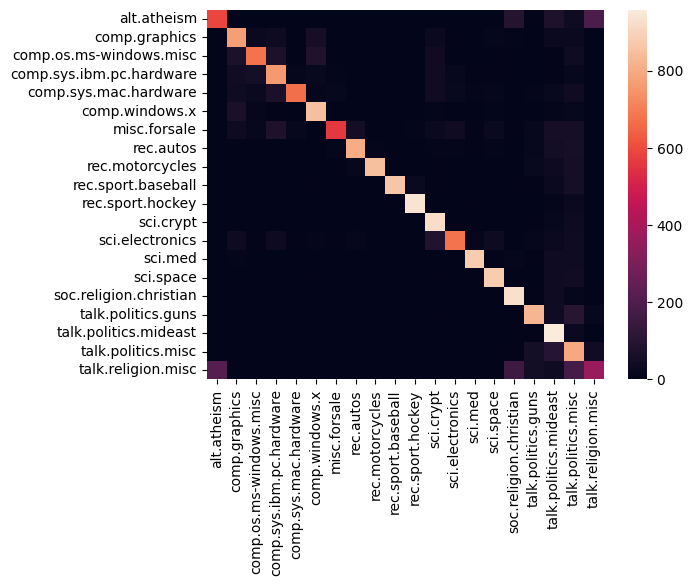

In [12]:
# Run k-fold cross-validation
run_validation("20_newsgroup.tsv", k=5)

# TODO:
# * experiment with preprocessing, feature extraction and 'hyperparameters'
# * evaluate and compare results

In [ ]:
# Train and save the final model
run_training("20_newsgroup.tsv", True) # True=verbose

In [ ]:
# Run the pre-trained model
run_inference()

Some test cases (generated with ChatGPT):
* `alt.atheism`: *Religion lacks empirical evidence to justify supernatural claims.*
* `soc.religion.christian`: *Faith in Jesus brings profound peace and eternal salvation.*
* `sci.med`: *Regular exercise contributes to overall well-being and disease prevention.*
* `sci.space`: *Satellite technology advances have revolutionized global communication networks.*
* `sci.space`: *The Kepler telescope's discovery of exoplanets revolutionizes our search for extraterrestrial life.*

## Try pandas & scikit-learn

See: https://pandas.pydata.org, https://scikit-learn.org

In [ ]:
!pip install pandas
!pip install scikit-learn

In [ ]:
## Create a tokenizer
import nltk
nltk.download('punkt_tab')  # Using the same tokenizer for consistency

def custom_tokenizer(text):
    return nltk.word_tokenize(text) # TODO: try Stanza, BPE, etc.

## Load a stoplist
with open("stoplist.txt", "r", encoding="utf-8") as file:
    custom_stoplist = [line.strip() for line in file if line.strip()]

In [20]:
## Train and cross-evaluate

import pandas

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Load a dataset
data_frame = pandas.read_csv("20_newsgroup.tsv", sep="\t", names=["label", "text"])

# Split train&dev and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data_frame["text"],
    data_frame["label"],
    test_size=0.2,                # 80% / 20%
    random_state=42,              # Ensure reproducibility
    stratify=data_frame["label"]  # Preserve class distribution in both sets
)

# Define a pipeline
pipeline = Pipeline([
    ('vec', CountVectorizer()),  # TODO: try with TfidfVectorizer, or static/contextual word embeddings
    ('clf', MultinomialNB())     # TODO: try another classifier, e.g. LogisticRegression
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'vec__max_features': [16000, 32000, 64000],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__lowercase': [True],
    'vec__tokenizer': [None, custom_tokenizer],  # None - default tokenizer
    'vec__stop_words': [None, custom_stoplist],  # vs. 'english' stoplist
    'clf__alpha': [0.1, 1.0]                     # Smoothing
}

# Conduct grid search with 5-fold cross-validation and accuracy-based scoring
# TODO: try RandomizedSearchCV instead
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Print the grid search results
for score, params in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
    print(score, params)

print("\nBest parameters:", grid.best_params_)
print("\nBest accuracy:", grid.best_score_)

# Retrieve the best model
best_model = grid.best_estimator_

# Evaluate the best model on the held-out test set
print("\nTest accuracy:", accuracy_score(y_test, best_model.predict(X_test)))

# Save the best model
import pickle
with open("nb_classifier-v2.pickle", "wb") as dmp:
    pickle.dump(best_model, dmp)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.8021755904153572 {'clf__alpha': 0.1, 'vec__lowercase': True, 'vec__max_features': 16000, 'vec__ngram_range': (1, 1), 'vec__stop_words': None, 'vec__tokenizer': None}
0.7633279661155932 {'clf__alpha': 0.1, 'vec__lowercase': True, 'vec__max_features': 16000, 'vec__ngram_range': (1, 1), 'vec__stop_words': None, 'vec__tokenizer': <function custom_tokenizer at 0x7ba65df7f4c0>}
0.8058216693990146 {'clf__alpha': 0.1, 'vec__lowercase': True, 'vec__max_features': 16000, 'vec__ngram_range': (1, 1), 'vec__stop_words': ['>', ',', 'the', '.', '--', 'to', 'of', 'a', 'and', ')', '(', 'i', 'in', 'is', ':', 'that', '@', "'ax", 'it', '?', "''", 'you', 'for', '``', '<', '!', 'this', 'on', 'not', '|', 'have', 'be', 'are', 'with', '#', "'s", '$', 'as', "n't", ';', '%', 'or', 'do', 'if', '-', 'was', 'but', 'they', ']', '[', 'from', '&', '...', 'by', 'at', 'can', 'would', 'what', 'an', 'there', "'", 'my', 'all', 'we', 'one', 'will', '`', 'about', 'he', 'has', 'so', 'your', 'no', 'any', 'me', 'who', 'some',

In [21]:
## Use the best model in production

texts = [
    "Religion lacks empirical evidence to justify supernatural claims.",
    "Faith in Jesus brings profound peace and eternal salvation.",
    "Regular exercise contributes to overall well-being and disease prevention.",
    "Satellite technology advances have revolutionized global communication networks.",
    "The Kepler telescope's discovery of exoplanets revolutionizes our search for extraterrestrial life."
]

predictions = best_model.predict(texts)
for text, label in zip(texts, predictions):
    print(f"TEXT: {text}\nLABEL: {label}\n")

TEXT: Religion lacks empirical evidence to justify supernatural claims.
LABEL: alt.atheism

TEXT: Faith in Jesus brings profound peace and eternal salvation.
LABEL: soc.religion.christian

TEXT: Regular exercise contributes to overall well-being and disease prevention.
LABEL: sci.med

TEXT: Satellite technology advances have revolutionized global communication networks.
LABEL: sci.crypt

TEXT: The Kepler telescope's discovery of exoplanets revolutionizes our search for extraterrestrial life.
LABEL: sci.space

